#Master Thesis Maria Banagou; Investigating the effect of emotional shift on pitch performance: insights from a data-driven facial expression video analysis

In [0]:
#@title Libraries
from os import listdir
from os.path import isfile, join
import random
import numpy as np
import pandas as pd
from keras.preprocessing import sequence
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix,f1_score
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Conv2D, MaxPooling2D, Dropout, Dense, Reshape, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier
from statsmodels.sandbox.stats.multicomp import multipletests
from statistics import mean
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

##Load data

In [0]:
#@title #Load survey data - performance scores
#Load the files
df2018= pd.read_excel('Startups1819_evaluations+rankings_allinvestors.xlsx')
df2019_1= pd.read_excel('Startups1920_1_evaluations+rankings_allinvestors.xlsx')
df2019_2= pd.read_excel('Startups1920_2_evaluations+rankings_allinvestors.xlsx')
df2019_DEIA= pd.read_excel('DEiAIII1920_SM1_evaluations+rankings_allinvestors.xlsx')

#Make a function that returns dictionary with the pitch and the mean score of perfromance 
def get_mean_scores(data):
  probinv =  []
  quality = []
  probsuc = []
  pitch = []
  names_y = ['probinv', 'quality', 'probsuc', 'pitch']
  for j in names_y:
    for i in range(1,len(data[j]),3):
      if j == 'probinv':
        probinv.append(data[j][i:i+3].mean())
      if j == 'quality':
        quality.append(data[j][i:i+3].mean())
      if j == 'probsuc': 
        probsuc.append(data[j][i:i+3].mean())
      if j == 'pitch':
        pitch.append(data[j][i])
  pitch_probinv = dict(zip(pitch, probinv))
  pitch_quality = dict(zip(pitch, quality))
  pitch_probsuc = dict(zip(pitch, probsuc))
  return(pitch_probinv, pitch_quality, pitch_probsuc)

#variables of the scores for all the files
df2018_probinv, df2018_quality, df2018_probsuc = get_mean_scores(df2018)
df2019_1_probinv, df2019_1_quality, df2019_1_probsuc = get_mean_scores(df2019_1)  
df2019_2_probinv, df2019_2_quality, df2019_2_probsuc = get_mean_scores(df2019_2) 
df2019_DEIA_probinv, df2019_DEIA_quality, df2019_DEIA_probsuc = get_mean_scores(df2019_DEIA)   

#Make a dictionary with all the pitches per variable(probability to invest, quality, probability success)
dfall_probinv = {}
for d in [df2018_probinv, df2019_1_probinv, df2019_2_probinv, df2019_DEIA_probinv]:
  dfall_probinv.update(d)

dfall_quality = {}
for d in [df2018_quality, df2019_1_quality, df2019_2_quality, df2019_DEIA_quality]:
  dfall_quality.update(d)

dfall_probsuc = {}
for d in [df2018_probsuc, df2019_1_probsuc, df2019_2_probsuc, df2019_DEIA_probsuc]:
  dfall_probsuc.update(d)

#The order is the same as in pitch data
pitches_order = ['Little Sister', 'FLIPR', 'Bubble Pop', 'RecognEyes', 'HOTIDY', 'FitPoint', 'SOLON', 'Ziggurat', 'PREA', 'Young Boosters', 'Whitebox', 'Soccer Academy', 'StudentFood', 'HoodFood', 'wAIste', 'Choos3 Wisely', 'LockUp', 'FindIT', 'SmArt', 'Peech', 'Ar-T-ficial', 'tAIste', 'Salix', 'Recipe-Me', 'Chattern']

#Take lists of scores in order as pitch data
scores_probinv = []
for i in pitches_order:
  scores_probinv.append(dfall_probinv.get(i))

scores_quality = []
for i in pitches_order:
  scores_quality.append(dfall_quality.get(i))

scores_probsuc = []
for i in pitches_order:
  scores_probsuc.append(dfall_probsuc.get(i))

#make the path to data file
#np.save('scores_probinb', scores_probinv)
#np.save('scores_quality',scores_quality)
#np.save('scores_probsuc', scores_probsuc)

In [0]:
#@title #Load pitch data
#make a list with the names of cvs files

files_pitch = [f for f in listdir(".") if isfile(join(".", f))]

#load the pitch data
datapitch = []
for i in files_pitch:
  datapitch.append(np.genfromtxt((i), skip_header=1, delimiter = ','))
datapitch = np.asarray(datapitch)

print(datapitch.shape)

#Let's have a look into the shapes of the data 
for i in range(datapitch.shape[0]):
  print(datapitch[i].shape)
#Get the index of confidence and success
import pandas as pd
check_p = pd.read_csv(files_pitch[0]) 
names_p = list(check_p.columns)
conf_ind_p = names_p.index(' confidence')
success_ind_p = names_p.index(' success')

#clean data, if confidence <90 or confidence is nan or success ==0 then delete
#note that if success == 1 then confidence is >90. But I keep it in the code as sanity check
for i in range(datapitch.shape[0]):
  x= []
  for j in range(datapitch[i].shape[0]):
    if datapitch[i][j,conf_ind_p]<0.90 or np.isnan(datapitch[i][j,conf_ind_p]) or datapitch[i][j,success_ind_p] == 0:
      x.append(j)
  datapitch[i]= np.delete(datapitch[i],x,0) 

#This function converts minutes into seconds
#It will be used to split the video into pitch and q_a
def count_sec(x):
  return (int(x) *60)+ (x- int(x))
#This list state the minute in which the pitch ends, the values were obtained by watching the video
#the values are listed in the same order as in files_pitch
minute = [3.33,3.15,5.38,3.26,3.15,3.25,5.30,3.22, 4.41, 2.49, 3.23, 5.08, 2.31, 3.03, 3.11, 2.59, 3.57, 3.38, 3.00, 4.17, 3.07, 4.43, 3.04, 9.23, 3.16]

#split the dataset into pitch and q_a 
pitch = []
q_a = []
for i in range(datapitch.shape[0]):
    pitch.append(datapitch[i][[np.where(datapitch[i][:,2]<=count_sec(minute[i]))]])
    q_a.append(datapitch[i][[np.where(datapitch[i][:,2]>count_sec(minute[i]))]])

for i in range(len(pitch)):
  pitch[i]= pitch[i].reshape(pitch[i].shape[1], pitch[i].shape[2])
  q_a[i]= q_a[i].reshape(q_a[i].shape[1], q_a[i].shape[2])

pitch= np.asarray(pitch)
q_a= np.asarray(q_a)

#let's have a look into the shapes of the data 
for i in range(pitch.shape[0]):
  print(pitch[i].shape,q_a[i].shape)

#keep only the au 
for i in range(pitch.shape[0]):
  pitch[i] = pitch[i][:,679:]
  q_a[i] = q_a[i][:,679:]



#reshape the data to be in allignment with the way we have trained the data
for i in range(pitch.shape[0]):
  pitch[i]= pitch[i][:int(pitch[i].shape[0]/90)*90,:]
  q_a[i]= q_a[i][:int(q_a[i].shape[0]/90)*90,:]
  pitch[i]= pitch[i].reshape(int(pitch[i].shape[0]/90),90,35)
  q_a[i]= q_a[i].reshape(int(q_a[i].shape[0]/90),90,35)

#np.save("pitch", pitch)
#np.save("q_a", q_a)

In [0]:
#@title # load test data (BAUM)
#make a list with the names of cvs files

files_test_t = [f for f in listdir(".") if isfile(join(".", f))]
del files_test_t[files_test_t.index('Annotations_BAUM1s.xlsx')]

#import numpy as np
#load the data
data_test_t = []
for i in files_test_t:
  data_test_t.append(np.genfromtxt((i),skip_header=1, delimiter = ','))

data_test_cl_t = np.asarray(data_test_t)


import pandas as pd
check = pd.read_csv(files_test_t[0]) 
names_t = list(check.columns)
conf_ind_t = names_t.index(' confidence')

#delete observations that have confidence less than 90%
for i in range(data_test_cl_t.shape[0]):
  x= []
  for j in range(data_test_cl_t[i].shape[0]):
    if data_test_cl_t[i][j,conf_ind_t]<0.90 or np.isnan(data_test_cl_t[i][j,conf_ind_t]):
      x.append(j)
  data_test_cl_t[i]= np.delete(data_test_cl_t[i],x,0)

#keep observations that have lenght> 88 
shape_test= []
for i in range(len(data_test_cl_t)):
  shape_test.append(data_test_cl_t[i].shape[0])
shape_test= np.array(shape_test)
data_test_cl_t = data_test_cl_t[(shape_test>=88)]

#delete raws after maxlen = 90
from keras.preprocessing import sequence
maxlen = 90
data_test_cl1_t = sequence.pad_sequences(data_test_cl_t, maxlen=maxlen, dtype = "float64")

#keep only the 35 action units 
test_data_t_f = data_test_cl1_t[:,:,679:]

#np.save('test_data_t_f', test_data_t_f)
#np.save('test_data_t_fs', test_data_t_f)

In [0]:
#@title # load test labels (BAUM)
files_test_t = np.array(files_test_t)[(shape_test>=88)]
#import pandas as pd
#load annotations
Annotations = pd.read_excel("Annotations_BAUM1s.xlsx") 
#take only the columns Clip Name ,  Emotion Code 
names_emotions = Annotations[["Clip Name", "Emotion Code"]].to_numpy()
#delete the cvs part from files_test names
names_test = np.array([x.split('.')[0] for x in files_test_t])
#take the labels
labs = []
for i in names_test:
  label = names_emotions[np.where(names_emotions[:,0] == i), 1][0]
  labs.append(label[0])
labels_bin_test_t = (np.asarray(labs) == 8).astype("int32").reshape((labels_test_t.shape[0],1))
print(np.unique(labels_bin_test_t, return_counts=True))
#np.save('labels_test_ts',labels_bin_test_t)

In [0]:
#@title # balance test data
lab0= np.where(labels_bin_test_t==0)[0]

random.seed( 30 )
ind_delete = random.sample(lab0.tolist(),16)
labels_test = np.delete(labels_bin_test_t,ind_delete,0)
print(np.unique(labels_test, return_counts=True))
x_test = np.delete(test_data_t_f,ind_delete, 0)
#make the path 
#np.save('labels_test', labels_test)
#np.save('x_test', x_test)

In [0]:
#@title # load labels of RAVDNESS 

#get the labels of the data


files = [f for f in listdir(".") if isfile(join(".", f))]
labels = np.array([files[x].split("-")[2] for x in range(len(files))])

labels_in = labels.astype(int)
labels_bin = (labels_in == 3).astype("int32").reshape((2452,1))
print(labels_bin.shape)
#see how many obs per label
print(set(labels))
[np.sum(labels == i) for i in set(labels)]
#save labels_bin numpy in data file

#np.save("labels_bin", labels_bin)

(2452, 1)
{'08', '02', '05', '07', '01', '06', '04', '03'}


[192, 376, 376, 192, 188, 376, 376, 376]

In [0]:
#@title # load data RAVDNESS

data = []
for i in files:
  data.append(np.genfromtxt((i), skip_header=1, delimiter = ','))
data = np.asarray(data)

#check the shape of each array
shape0= []
for i in range(data.shape[0]):
  shape0.append(data[i].shape[0])
print(min(shape0))

# find the index of confidence variable 
import pandas as pd
check = pd.read_csv(files[0]) 
names = list(check.columns)
conf_ind = names.index('confidence')

#delete observations that have confidence less than 90%
for i in range(data.shape[0]):
  x= []
  for j in range(data[i].shape[0]):
    if data[i][j,conf_ind]<0.90 or np.isnan(data[i][j,conf_ind]):
      x.append(j)
  data[i]= np.delete(data[i],x,0)

#check the shape of the clean data 
#and whether the min is different (it's not)
shape= []
for i in range(data.shape[0]):
  shape.append(data[i].shape[0])
print(min(shape))

#check if the shapes before and after cleaning are the same 
print(shape== shape0)
      
#see how many and which observations were deleted 
c= 0 
x= []
for i in range(len(shape)):
  if shape[i] != shape0[i]:
    c+=1
    x.append(i)
print(c,x)

#keep only the auction units
data_au= []
for i in range(data.shape[0]):
  data_au.append(data[i][:,677:])
data_au= np.asarray(data_au)

#pad the sequences

maxlen = 90
data_cl90 = sequence.pad_sequences(data_au, maxlen=maxlen, dtype = "float64")

#np.save("data_cl90_conf", data_cl90)

88
88
False
100 [85, 94, 108, 114, 115, 122, 153, 161, 177, 182, 183, 184, 193, 194, 202, 205, 206, 207, 217, 218, 223, 225, 229, 230, 232, 240, 241, 246, 251, 263, 264, 367, 379, 387, 402, 406, 410, 425, 452, 545, 614, 679, 721, 802, 813, 914, 986, 991, 992, 1016, 1033, 1034, 1051, 1057, 1058, 1064, 1076, 1184, 1205, 1439, 1444, 1457, 1524, 1527, 1528, 1529, 1537, 1541, 1546, 1548, 1551, 1552, 1553, 1554, 1560, 1564, 1565, 1570, 1575, 1577, 1578, 1579, 1580, 1588, 1594, 1601, 1602, 1714, 1721, 1733, 1805, 1970, 2063, 2090, 2101, 2123, 2125, 2177, 2264, 2273]


Using TensorFlow backend.


In [0]:
#@title load all the data from directory as numpy 


test_data = np.load("x_test.npy", allow_pickle= True)
labels_test = np.load("labels_test.npy", allow_pickle= True)
labels_tr = np.load("labels_bin.npy", allow_pickle= True)
train_data = np.load("data_cl90_conf.npy", allow_pickle= True)
pitch_data = np.load("pitch.npy", allow_pickle= True)
q_a_data = np.load("q_a.npy", allow_pickle= True)
scores_probinv = np.load('scores_probinb.npy', allow_pickle =True)
scores_quality = np.load('scores_quality.npy', allow_pickle = True)
scores_probsuc = np.load('scores_probsuc.npy',allow_pickle = True)

print("test data and labels shape: ", test_data.shape, labels_test.shape, '\ntrain data and labels shape', train_data.shape, labels_tr.shape,'\npitch and q&a data shape', pitch_data.shape, q_a_data.shape, '\nperformance scores shape', scores_probinv.shape, scores_quality.shape, scores_probsuc.shape)


test data and labels shape:  (166, 90, 35) (166, 1) 
train data and labels shape (2452, 90, 35) (2452, 1) 
pitch and q&a data shape (25,) (25,) 
performance scores shape (25,) (25,) (25,)


##EDA

In [0]:
#@title Prepare data for plots 
#Training data 
not_h_17 = train_data[labels_tr.squeeze() == 0,:,:17].mean(axis=1).mean(axis=0)
not_h_18 = train_data[labels_tr.squeeze() == 0,:,17:].mean(axis=1).mean(axis=0)
happy_17 = train_data[labels_tr.squeeze() == 1,:,:17].mean(axis =1).mean(axis =0)
happy_18 = train_data[labels_tr.squeeze() == 1,:,17:].mean(axis =1).mean(axis =0)

#Test data
not_h_17_t= test_data[labels_test.squeeze() == 0,:,:17].mean(axis=1).mean(axis=0)
not_h_18_t = test_data[labels_test.squeeze() == 0,:,17:].mean(axis=1).mean(axis=0)
happy_17_t = test_data[labels_test.squeeze() == 1,:,:17].mean(axis =1).mean(axis =0)
happy_18_t = test_data[labels_test.squeeze() == 1,:,17:].mean(axis =1).mean(axis =0)

#prepare the pitch and q&a data for plots; mean auction units per group(pitch and q&a)
#pitch
x= []
for i in range(len(pitch_data)):
  x.append(pitch_data[i].mean(axis=1).mean(axis =0))
pitch_plot = np.array(x).mean(axis=0)

#q&a
x= []
for i in range(len(q_a_data)):
  x.append(q_a_data[i].mean(axis=1).mean(axis =0))
q_a_plot = np.array(x).mean(axis=0)

#Descriptives statistics of probabilty to invest 
print(scores_probinv.max(),scores_probinv.min(),scores_probinv.mean(),scores_probinv.std())


71.66666666666667 1.6666666666666667 32.15277777777778 18.661700521603724


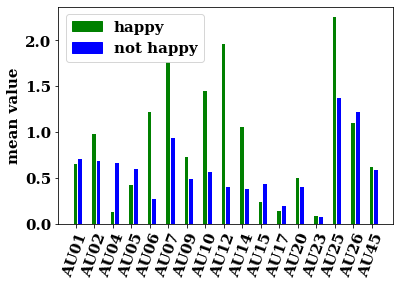

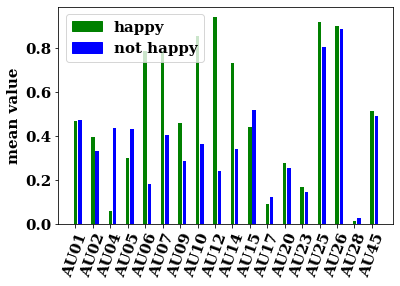

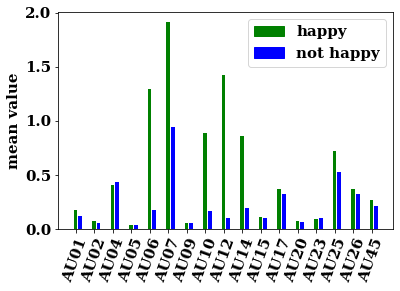

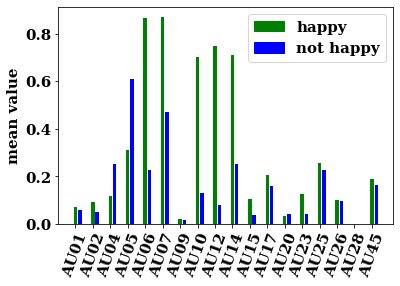

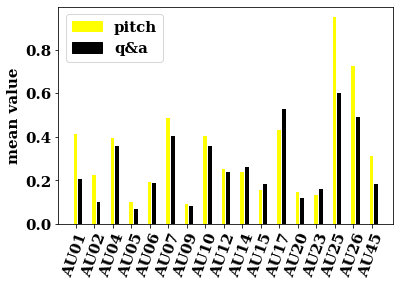

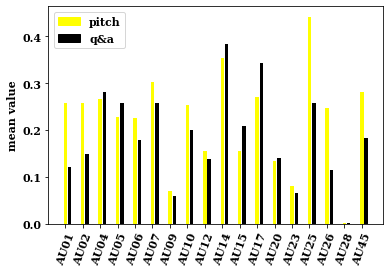

In [0]:
#@title plots



#Plot happy vs not happy for the insensity of the 17 auction units RAVDNESS
#plt.title('Plot happy vs not happy for insensity of the 17 auction units')
X =['AU01', 'AU02', 'AU04', 'AU05', 'AU06', 'AU07', 'AU09', 'AU10', 'AU12', 'AU14', 'AU15', 'AU17', 'AU20', 'AU23', 'AU25', 'AU26', 'AU45']
L = np.arange(17)
plt.bar(X , happy_17, color = 'g', width = 0.20)
plt.bar(L+0.25 ,not_h_17, color = 'b', width = 0.20)
plt.xticks(rotation=70)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
colors = {'happy':'green', 'not happy':'blue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.ylabel('mean value')
plt.rc('font', family='serif', size=15)
#fig = plt.gcf()
#fig.set_size_inches(8, 6)
#fig.savefig('17_train.png', dpi=80)

plt.show()

# Plot happy vs not happy for the presence of the 18 auction units RAVDNESS
#plt.title('Plot happy vs not happy for presence of the 18 auction units')
X = ['AU01', 'AU02', 'AU04', 'AU05', 'AU06', 'AU07', 'AU09', 'AU10', 'AU12', 'AU14', 'AU15', 'AU17', 'AU20', 'AU23', 'AU25', 'AU26', 'AU28', 'AU45']
L = np.arange(18)
plt.bar(X , happy_18, color = 'g', width = 0.20)
plt.bar(L+0.25 ,not_h_18, color = 'b', width = 0.20)
plt.xticks(rotation=70)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
colors = {'happy':'green', 'not happy':'blue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.ylabel('mean value')
plt.rc('font', family='serif', size=15)
#fig = plt.gcf()
#fig.set_size_inches(8, 6)
#fig.savefig('18_train.png', dpi=80)

plt.show()

#Plot happy vs not happy for the insensity of the 17 auction units for the test set BAUM-1
#plt.title('Plot happy vs not happy for the insensity of the 17 auction units for the test set')
X =['AU01', 'AU02', 'AU04', 'AU05', 'AU06', 'AU07', 'AU09', 'AU10', 'AU12', 'AU14', 'AU15', 'AU17', 'AU20', 'AU23', 'AU25', 'AU26', 'AU45']
L = np.arange(17)
plt.bar(X , happy_17_t, color = 'g', width = 0.20)
plt.bar(L+0.25 ,not_h_17_t, color = 'b', width = 0.20)
plt.xticks(rotation=70)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
colors = {'happy':'green', 'not happy':'blue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.ylabel('mean value')
plt.rc('font', family='serif', size=15)
#fig = plt.gcf()
#fig.set_size_inches(8, 6)
#fig.savefig('17_test.png', dpi=80)

plt.show()

#Plot happy vs not happy for the presence of 18 auction units for the test set BAUM-1
#plt.title('Plot happy vs not happy for the presence  of the 18 auction units for the test set')
X = ['AU01', 'AU02', 'AU04', 'AU05', 'AU06', 'AU07', 'AU09', 'AU10', 'AU12', 'AU14', 'AU15', 'AU17', 'AU20', 'AU23', 'AU25', 'AU26', 'AU28', 'AU45']
L = np.arange(18)
plt.bar(X , happy_18_t, color = 'g', width = 0.20)
plt.bar(L+0.25 ,not_h_18_t, color = 'b', width = 0.20)
plt.xticks(rotation=70)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
colors = {'happy':'green', 'not happy':'blue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.ylabel('mean value')
plt.rc('font', family='serif', size=15)

#fig = plt.gcf()
#fig.set_size_inches(8, 6)
#fig.savefig('18_test.png', dpi=80)

plt.show()

#Plot for insensity of the 17 auction units for pitch and q&a data
#plt.title('Plot for the insensity of the 17 auction units for pitch and q&a data')
X =['AU01', 'AU02', 'AU04', 'AU05', 'AU06', 'AU07', 'AU09', 'AU10', 'AU12', 'AU14', 'AU15', 'AU17', 'AU20', 'AU23', 'AU25', 'AU26', 'AU45']
L = np.arange(17)
plt.bar(X , pitch_plot[:17], color = 'yellow', width = 0.20)
plt.bar(L+0.25 ,q_a_plot[:17], color = 'black', width = 0.20)
plt.xticks(rotation=70)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
colors = {'pitch':'yellow', 'q&a':'black'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.ylabel('mean value')
plt.rc('font', family='serif', size=11)

#fig = plt.gcf()
#fig.set_size_inches(8, 6)
#fig.savefig('17_p.png', dpi=80)

plt.show()

#Plot for presence of the 18 auction units for pitch and Q&A
#plt.title('Plot happy vs not happy for the presence of the 18 auction units')
X = ['AU01', 'AU02', 'AU04', 'AU05', 'AU06', 'AU07', 'AU09', 'AU10', 'AU12', 'AU14', 'AU15', 'AU17', 'AU20', 'AU23', 'AU25', 'AU26', 'AU28', 'AU45']
L = np.arange(18)
plt.bar(X , pitch_plot[17:], color = 'yellow', width = 0.20)
plt.bar(L+0.25 ,q_a_plot[17:], color = 'black', width = 0.20)
plt.xticks(rotation=70)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
colors = {'pitch':'yellow', 'q&a':'black'}          
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.ylabel('mean value')
plt.rc('font', family='serif', size=15)
#fig = plt.gcf()
#fig.set_size_inches(8, 6)
#fig.savefig('18_p.png', dpi=80)

plt.show()

##Preprocessing 

In [0]:
#@title # Function for downsampling and split into train, val, test set 
def downsampling_split(data, rawlabels):
  xTrainall, xTestall, yTrainall, yTestall = train_test_split(data,rawlabels, test_size = 0.08, random_state = 0)

  #Save the min number of class to use it for downsampling 
  n_samples = min(np.unique(yTrainall, return_counts=True)[1])

  #I have to change the shape of ytrain to concatenate the data 
  x8= np.zeros((yTrainall.shape[0],90,1))
  for i in range(yTrainall.shape[0]):
    if yTrainall[i] == 1:
      x8[i]=1
    if yTrainall[i] == 2:
      x8[i]=2
    if yTrainall[i] == 3:
      x8[i]=3
    if yTrainall[i] == 4:
      x8[i]=4
    if yTrainall[i] == 5:
      x8[i]=5
    if yTrainall[i] == 6:
      x8[i]=6
    if yTrainall[i] == 7:
      x8[i]=7
    if yTrainall[i] == 8:
      x8[i]=8 


  # concatenate our training data back together
  X8 = np.concatenate([xTrainall, x8.reshape(x8.shape[0],90,1)], axis = 2)

  ## separate classes
  not_happy_1= X8[np.where(yTrainall==1)[0],:,:]
  happy = X8[np.where(yTrainall==3)[0],:,:]
  not_happy_2= X8[np.where(yTrainall==2)[0],:,:]
  not_happy_4= X8[np.where(yTrainall==4)[0],:,:]
  not_happy_5= X8[np.where(yTrainall==5)[0],:,:]
  not_happy_6= X8[np.where(yTrainall==6)[0],:,:]
  not_happy_7= X8[np.where(yTrainall==7)[0],:,:]
  not_happy_8= X8[np.where(yTrainall==8)[0],:,:]

  c1 = resample(not_happy_1, replace = False, # sample without replacement
                                  n_samples = n_samples, # match minority n
                                  random_state = 27)
  c2 = resample(not_happy_2, replace = False, # sample without replacement
                                  n_samples = n_samples, # match minority n
                                  random_state = 27)
  c4 = resample(not_happy_4, replace = False, # sample without replacement
                                  n_samples = n_samples, # match minority n
                                  random_state = 27)
  c5 = resample(not_happy_5, replace = False, # sample without replacement
                                  n_samples = n_samples, # match minority n
                                  random_state = 27)
  c6 = resample(not_happy_6, replace = False, # sample without replacement
                                  n_samples = n_samples, # match minority n
                                  random_state = 27)
  c7 = resample(not_happy_7, replace = False, # sample without replacement
                                  n_samples = n_samples, # match minority n
                                  random_state = 27)
  c8 = resample(not_happy_8, replace = False, # sample without replacement
                                  n_samples = n_samples, # match minority n
                                  random_state = 27)

  downsample = np.concatenate([c1, c2, c4, c5, c6, c7, c8, happy])
  #make the labels
  labels_down = np.zeros((downsample.shape[0],1))
  for i in range(downsample.shape[0]):
    if downsample[i,1,35]== 3:
      labels_down[i] = 1

  
  #keep only the au and delete the label
  downsample_tr= downsample[:,:,:35]

  

  #make the labels for the test set
  yTestall = (yTestall == 3).astype("int32").reshape((yTestall.shape[0],1))
  yTrainall = (yTrainall == 3).astype("int32").reshape((yTrainall.shape[0],1))


  xTrain_d, xVal, yTrain_d, yVal = train_test_split(downsample_tr, labels_down, test_size = 0.10, random_state = 0)

  return (xTrainall, xTestall, yTrainall, yTestall, xTrain_d, xVal, yTrain_d, yVal,downsample_tr, labels_down)


In [0]:
#@title # Function for upsampling
def upsampling(data, y):
  xtr, xval, ytrain, yval = train_test_split(data, y, 
                                             test_size = 0.10,
                                             random_state = 0)
  
  #change the shape of ytrain to concatenate the data and y 
  x= np.zeros((ytrain.shape[0],90,1))
  for i in range(ytrain.shape[0]):
    if ytrain[i] == 1:
      x[i]=1

  # concatenate our training data back together
  X = np.concatenate([xtr, x], axis = 2)
  
  # separate minority and majority classes
  not_happy= X[np.where(ytrain==0)[0],:,:]
  happy = X[np.where(ytrain==1)[0],:,:]

  # upsample minority
  happy_upsampled = resample(happy,
                            replace=True, # sample with replacement
                            n_samples= 550,#len(not_happy), # match number in majority class
                            random_state=27) # reproducible results
  # combine majority and upsampled minority
  upsampled = np.concatenate([not_happy, happy_upsampled])

  #make the labels
  labels_up = np.zeros((upsampled.shape[0]))
  for i in range(upsampled.shape[0]):
    if upsampled[i,1,35]== 1:
      labels_up[i] = 1


  upsampled_tr= upsampled[:,:,:35]
  

  labels_up= labels_up.reshape(labels_up.shape[0],1)

  return(upsampled_tr, labels_up, xval, yval)

In [0]:
#@title Make all 6 datasets: Downsampled,upsampled, all data for standardized (and not) data
labels_8= labels_bin #this is the labels for all 8 emotions
#Unstandardize data
xTrainall, xTestall, yTrainall, yTestall, xTrain_d, xVal_d, yTrain_d, yVal_d, downsample_tr, labels_down = downsampling_split(train_data, labels_8)
#xallup,yallup = upsampling(xTrainall, yTrainall) #I save these variables in case that I need them for grid search
xTrain_up, yTrain_up,xVal_up, yVal_up = upsampling(xTrainall, yTrainall)
xTrain, xVal, yTrain,  yVal = train_test_split(xTrainall, yTrainall, test_size = 0.10, random_state = 0)

###stard
#make a function that calculates the mean and std per action units
def mean_st(data):
  mean  = data.reshape(data.shape[0]*data.shape[1],35).mean(axis=0)
  st    = data.reshape(data.shape[0]*data.shape[1],35).std(axis=0)
  return (mean, st)
mean_train_all, std_train_all = mean_st(train_data)
train_data_st_d = (train_data - mean_train_all) / std_train_all
train_data_st_up = (xTrainall- mean_train_all)/ std_train_all
test_data_st_up = (xTestall - mean_train_all) / std_train_all
test_data_st_ex = (test_data - mean_train_all) / std_train_all

#Standardize data
xTrainall_s, xTestall_s, yTrainall_s, yTestall_s, xTrain_d_s, xVal_d_s, yTrain_d_s, yVal_d_s, downsample_tr_s, labels_down_s = downsampling_split(train_data_st_d, labels_8)
#xallup_s,yallup_s = upsampling(train_data_st_up, yTrainall) #I save these variables in case that I need them for grid search
xTrain_up_s, yTrain_up_s, xVal_up_s, yVal_up_s = upsampling(train_data_st_up, yTrainall)
xTrain_s,  xVal_s, yTrain_s, yVal_s = train_test_split(train_data_st_up, yTrainall, test_size = 0.10, random_state = 0)


In [0]:
#@title Shape of data
print('Upsampled train set shape: ',xTrain_up.shape, xTrain_up[yTrain_up.squeeze()==1].shape, xTrain_up[yTrain_up.squeeze()==0].shape)
print("Downsampled train set shape: ", xTrain_d.shape, xTrain_d[yTrain_d.squeeze()==1].shape, xTrain_d[yTrain_d.squeeze()==0].shape )
print('internal test set shape: ', xTestall.shape, xTestall[yTestall.squeeze()==1].shape  )
print('shape of all train data: ', train_data.shape, train_data[labels_tr.squeeze()==1].shape, train_data[labels_tr.squeeze()==0].shape)
print('external test set shape', test_data.shape, test_data[labels_test.squeeze()==1].shape, test_data[labels_test.squeeze()==0].shape)

Upsampled train set shape:  (2271, 90, 35) (550, 90, 35) (1721, 90, 35)
Downsampled train set shape:  (1376, 90, 35) (311, 90, 35) (1065, 90, 35)
internal test set shape:  (197, 90, 35) (30, 90, 35)
shape of all train data:  (2452, 90, 35) (376, 90, 35) (2076, 90, 35)
external test set shape (166, 90, 35) (83, 90, 35) (83, 90, 35)


In [0]:
#@title print the dif in mean and std among datasets


#print the mean and st of the internal and external dataset
print('internal dataset')
mean_tr, std_tr = mean_st(xTrain_d)
mean_val, std_val = mean_st(xVal)
mean_test, std_test = mean_st(xTestall)
print("mean dif valid set: ",mean_tr-mean_val,"\n mean dif test set: ", mean_tr - mean_test, 
        "\nst dif valid set: ",std_tr-std_val,"\nstd dif test set: ", std_tr - std_test)

print('\nexternal dataset')
mean_extern_test, std_extern_test = mean_st(test_data)

print('mean dif external test set: ', mean_extern_test- mean_train_all,
        '\nstd dif external test set: ', std_extern_test - std_train_all)


##LSTM

In [0]:
#@title #Function that gives the acc and f1 for lstm
def acc_f1(xtrain, xval, ytrain, yval, binary= True):
  
  filepath= "weightsfunction.best.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, 
                               save_best_only=True, mode='auto')

  if binary:
    xtrain = xtrain[:,:,17:]
    xval = xval[:,:,17:]
    shape= xtrain.shape[2]
  else:
    xtrain = xtrain[:,:,:17]
    xval = xval[:,:,:17]
    shape = xtrain.shape[2]

  model = Sequential()
  model.add(LSTM(70, input_shape=(90, shape)))
  model.add(Dense(1 , activation = "sigmoid"))
  model.compile(loss='binary_crossentropy', optimizer='Adam', metrics = ["acc"])
  # fit network
  history = model.fit(xtrain, ytrain, epochs=100, batch_size=80, 
                      verbose=0, shuffle=False, 
                      validation_data = (xval, yval),
                      callbacks= [checkpoint])
  
  #Load weights of best model
  model.load_weights("weightsfunction.best.hdf5")
  #Compile model 
  model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['acc'])

  val_acc_model = model.evaluate(xval, yval)
  pred = np.array(model.predict(xval).squeeze() > 0.5).astype("int32")
  f1 = f1_score(yval, pred) 

  return(val_acc_model, f1)

    

In [0]:
#@title Get the acc and f1 score for lstm for all 12 datasets to define the best dataset; preprocessing
acc_d_17, f1_d_17 = acc_f1(xTrain_d, xVal_d, yTrain_d, yVal_d, binary = False)
acc_d_18, f1_d_18 = acc_f1(xTrain_d, xVal_d, yTrain_d, yVal_d, binary = True)
acc_up_17, f1_up_17 = acc_f1(xTrain_up, xVal_up, yTrain_up, yVal_up, binary = False)
acc_up_18, f1_up_18 = acc_f1(xTrain_up, xVal_up, yTrain_up, yVal_up, binary = True)
acc_all_17, f1_all_17 = acc_f1(xTrain, xVal, yTrain, yVal, binary = False)
acc_all_18, f1_all_18 = acc_f1(xTrain, xVal, yTrain, yVal, binary = True)

acc_d_17_s, f1_d_17_s = acc_f1(xTrain_d_s, xVal_d_s, yTrain_d_s, yVal_d_s, binary = False)
acc_d_18_s, f1_d_18_s = acc_f1(xTrain_d_s, xVal_d_s, yTrain_d_s, yVal_d_s, binary = True)
acc_up_17_s, f1_up_17_s = acc_f1(xTrain_up_s, xVal_up_s, yTrain_up_s, yVal_up_s, binary = False)
acc_up_18_s, f1_up_18_s = acc_f1(xTrain_up_s, xVal_up_s, yTrain_up_s, yVal_up_s, binary = True)
acc_all_17_s, f1_all_17_s = acc_f1(xTrain_s, xVal, yTrain, yVal, binary = False)
acc_all_18_s, f1_all_18_s = acc_f1(xTrain, xVal, yTrain, yVal, binary = True)

In [0]:
#@title Print the acc and f1 per model; lstm

names_data = ['downsample_17','downsample_18', 'upsample_17', 'upsample_18', 'all_data_17', 'all_data_18', 'downsample_st_17', 'downsample_st_18', 'upsample_st_17', 'upsample_st_18', 'all_data_st_17', 'all_data_st_18' ]
acc_data_lstm = [ acc_d_17, acc_d_18, acc_up_17, acc_up_18, acc_all_17, acc_all_18, acc_d_17_s, acc_d_18_s, acc_up_17_s, acc_up_18_s, acc_all_17_s, acc_all_18_s ]
f1_data_lstm = [ f1_d_17, f1_d_18, f1_up_17, f1_up_18, f1_all_17, f1_all_18, f1_d_17_s, f1_d_18_s, f1_up_17_s, f1_up_18_s, f1_all_17_s, f1_all_18_s ]


models_summary_lstm = pd.DataFrame(list(zip(names_data,acc_data_lstm,f1_data_lstm)), columns = ['names','loss     validation accuracy', 'f1'])
print(models_summary_lstm)
#models_summary_lstm.to_csv(r'/content/drive/My Drive/thesis/data/summary_lstm_loss2.csv', index = False, header=True)
#all_data_18   [0.0829424038529396, 0.9734513163566589]  0.921053

In [0]:
#@title make the model for gridsearch

def create_model(neurons = 100, activation = 'relu', learn_rate = 0.01,  hidden_layers=1): 
  model = Sequential()
  model.add(LSTM(neurons, input_shape=(90, 18)))
  for i in range(hidden_layers):
    model.add(Dense(neurons, activation=activation))
  model.add(Dense(1 , activation = "sigmoid"))
  adam = Adam(lr=learn_rate)
  model.compile(loss='binary_crossentropy', optimizer = adam, metrics = ["acc"])
  return model

In [0]:
#@title Gridsearch for LSTM 
seed = 7
np.random.seed(seed)

model = KerasClassifier(build_fn=create_model, verbose=0)

batch_size = [32, 72, 80] #[50, 72, 80, 100]
epochs = [50, 80]
#optimizer = ['RMSprop', 'Adagrad', 'Adadelta', 'Adam' ]  #['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'] 
learn_rate = [0.001, 0.01] 
hidden_layers= [0,1]
neurons = [70, 100]
#momentum = [0.0, 0.2, 0.6]
#activation = ['softmax', 'relu', 'tanh', 'linear']
cross_validation = StratifiedKFold(n_splits=3, shuffle=True,  random_state = 2)
param_grid = dict(epochs = epochs, batch_size = batch_size, learn_rate = learn_rate, hidden_layers = hidden_layers, neurons= neurons) #, activation = activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv =cross_validation, scoring = 'f1')
grid_result = grid.fit(xTrainall[:,:,17:], yTrainall)

#print best parameters and  f1 score
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))

#Best: 0.861142 using {'batch_size': 80, 'epochs': 80, 'hidden_layers': 1, 'learn_rate': 0.01, 'neurons': 70}

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [0]:
#@title Fit LSTM with best parameters


filepath="weightsd_178.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto')

model = Sequential()
model.add(LSTM(70, input_shape=(90, 18)))
model.add(Dense(70, activation = 'relu'))
model.add(Dense(1 , activation = "sigmoid"))
adam = Adam(lr=0.01)
model.compile(loss='binary_crossentropy', optimizer= adam, metrics = ["acc"])
# fit network
history = model.fit(xTrain[:,:,17:], yTrain, epochs=80, batch_size=80, verbose=2, shuffle=False, validation_data = (xVal[:,:,17:], yVal), callbacks= [checkpoint])
# plot history
#pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='test')
#pyplot.legend()
#pyplot.show()


model.load_weights("weightsd_178.best.hdf5")
# Compile model (required to make predictions)
model.compile(loss='binary_crossentropy', optimizer= adam, metrics=['acc'])
print("Created model and loaded weights from file")



Created model and loaded weights from file


In [0]:
#@title Get the accuracy and f1 score for lstm model final

print('Train set')
print('Evaluate on train set')
results_train_lstm = model.evaluate(xTrain[:,:,17:], yTrain)
print('train loss, train acc:', results_train_lstm)

predtest_train = np.array(model.predict(xTrain[:,:,17:]).squeeze() > 0.5).astype("int32")
print('confusion matrix \n', confusion_matrix(yTrain, predtest_train))
f1_train_lstm = f1_score(yTrain, predtest_train)
print('F1: ', f1_train_lstm)

print('Validation set')
print('\n# Evaluate on validation')
results_val_lstm = model.evaluate(xVal[:,:,17:], yVal)
print('val loss, val acc:', results_val_lstm)

predtest_val = np.array(model.predict(xVal[:,:,17:]).squeeze() > 0.5).astype("int32")
print('confusion matrix \n', confusion_matrix(yVal, predtest_val))
f1_val_lstm = f1_score(yVal, predtest_val)
print('F1: ', f1_val_lstm)

print('\nInternal Test set')
print('Evaluate on internal test data')
results_test_in = model.evaluate(xTestall[:,:,17:], yTestall)
print('test loss, test acc:', results_test_in)

predtest_in = np.array(model.predict(xTestall[:,:,17:]).squeeze() > 0.5).astype("int32")
print('confusion matrix \n', confusion_matrix(yTestall, predtest_in))
f1_test_in_lstm = f1_score(yTestall, predtest_in)
print('F1: ' ,f1_test_in_lstm)

print("\nExternal Test set")
pred_ex = np.array(model.predict(test_data[:,:,17:]).squeeze() > 0.5).astype("int32")

print('Evaluate on external test data')
results_test_ex = model.evaluate(test_data[:,:,17:], labels_test)
print('test loss, test acc:', results_test_ex)

print('confusion matrix \n', confusion_matrix(labels_test, pred_ex))
f1_test_ex_lstm = f1_score(labels_test, pred_ex)
print('F1: ', f1_test_ex_lstm )

Train set
Evaluate on train set
64/64 [==============================] - 0s 3ms/step - loss: 0.0685 - acc: 0.9744
train loss, train acc: [0.06853938102722168, 0.974371612071991]
confusion matrix 
 [[1707   14]
 [  38  270]]
F1:  0.9121621621621622
Validation set

# Evaluate on validation
8/8 [==============================] - 0s 3ms/step - loss: 0.1206 - acc: 0.9690
val loss, val acc: [0.12055465579032898, 0.9690265655517578]
confusion matrix 
 [[186   2]
 [  5  33]]
F1:  0.904109589041096

Internal Test set
Evaluate on internal test data
7/7 [==============================] - 0s 3ms/step - loss: 0.1721 - acc: 0.9492
test loss, test acc: [0.1720949411392212, 0.9492385983467102]
confusion matrix 
 [[165   2]
 [  8  22]]
F1:  0.8148148148148148

External Test set
Evaluate on external test data
6/6 [==============================] - 0s 3ms/step - loss: 0.9953 - acc: 0.8253
test loss, test acc: [0.9953385591506958, 0.8253012299537659]
confusion matrix 
 [[77  6]
 [23 60]]
F1:  0.8053691275

##CNN-LSTM

In [0]:
#@title #Function that gives the acc and f1 for cnn
 
def acc_f1_cnn(xtrain, xval, ytrain, yval, binary= True):
  xtrain = xtrain.reshape(xtrain.shape[0], xtrain.shape[1], xtrain.shape[2], 1)
  xval = xval.reshape(xval.shape[0], xval.shape[1], xval.shape[2], 1)

  filepath= "weightsfunctioncnn.best.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, 
                               save_best_only=True, mode='auto')

  if binary:
    xtrain = xtrain[:,:,17:,:]
    xval = xval[:,:,17:,:]
    shape= xtrain.shape[2]
  else:
    xtrain = xtrain[:,:,:17,:]
    xval = xval[:,:,:17,:]
    shape = xtrain.shape[2]



  # Create a sequential model
  model = Sequential()

  # Add convolutional and pooling layers
  model.add(Input((90, shape,1)))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.3))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Dense(40, activation = 'relu'))
  model.add(Reshape((-1,40)))
  model.add(LSTM(50))
  model.add(Dense(1 , activation = "sigmoid"))
  model.compile(loss='binary_crossentropy', optimizer='Adam', metrics = ["acc"])

  
 
  # fit network
  history = model.fit(xtrain, ytrain, epochs=100, batch_size=72, 
                      verbose=0, shuffle=False, 
                      validation_data = (xval, yval),
                      callbacks= [checkpoint])
  
  #Load weights of best model
  model.load_weights("weightsfunctioncnn.best.hdf5")
  #Compile model 
  model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['acc'])

  val_acc_model = model.evaluate(xval, yval)
  pred = np.array(model.predict(xval).squeeze() > 0.5).astype("int32")
  f1 = f1_score(yval, pred) 

  return(val_acc_model, f1)

    

In [0]:
#@title get the acc f1 score for cnn-lstm model to define the best dataset; preprocessing 
acc_d_17_cnn, f1_d_17_cnn = acc_f1_cnn(xTrain_d, xVal_d, yTrain_d, yVal_d, binary = False)
acc_d_18_cnn, f1_d_18_cnn = acc_f1_cnn(xTrain_d, xVal_d, yTrain_d, yVal_d, binary = True)
acc_up_17_cnn, f1_up_17_cnn = acc_f1_cnn(xTrain_up, xVal_up, yTrain_up, yVal_up, binary = False)
acc_up_18_cnn, f1_up_18_cnn = acc_f1_cnn(xTrain_up, xVal_up, yTrain_up, yVal_up, binary = True)
acc_all_17_cnn, f1_all_17_cnn = acc_f1_cnn(xTrain, xVal, yTrain, yVal, binary = False)
acc_all_18_cnn, f1_all_18_cnn = acc_f1_cnn(xTrain, xVal, yTrain, yVal, binary = True)

acc_d_17_s_cnn, f1_d_17_s_cnn = acc_f1_cnn(xTrain_d_s, xVal_d_s, yTrain_d_s, yVal_d_s, binary = False)
acc_d_18_s_cnn, f1_d_18_s_cnn = acc_f1_cnn(xTrain_d_s, xVal_d_s, yTrain_d_s, yVal_d_s, binary = True)
acc_up_17_s_cnn, f1_up_17_s_cnn = acc_f1_cnn(xTrain_up_s, xVal_up_s, yTrain_up_s, yVal_up_s, binary = False)
acc_up_18_s_cnn, f1_up_18_s_cnn = acc_f1_cnn(xTrain_up_s, xVal_up_s, yTrain_up_s, yVal_up_s, binary = True)
acc_all_17_s_cnn, f1_all_17_s_cnn = acc_f1_cnn(xTrain_s, xVal, yTrain, yVal, binary = False)
acc_all_18_s_cnn, f1_all_18_s_cnn = acc_f1_cnn(xTrain, xVal, yTrain, yVal, binary = True)


8/8 [==============================] - 0s 6ms/step - loss: 0.1344 - acc: 0.9602


In [0]:
#@title Print the acc and f1 per model; cnn-lstm
names_data = ['downsample_17','downsample_18', 'upsample_17', 'upsample_18', 'all_data_17', 'all_data_18', 'downsample_st_17', 'downsample_st_18', 'upsample_st_17', 'upsample_st_18', 'all_data_st_17', 'all_data_st_18' ]
acc_data_cnn = [ acc_d_17_cnn, acc_d_18_cnn, acc_up_17_cnn, acc_up_18_cnn, acc_all_17_cnn, acc_all_18_cnn, acc_d_17_s_cnn, acc_d_18_s_cnn, acc_up_17_s_cnn, acc_up_18_s_cnn, acc_all_17_s_cnn, acc_all_18_s_cnn ]
f1_data_cnn = [ f1_d_17_cnn, f1_d_18_cnn, f1_up_17_cnn, f1_up_18_cnn, f1_all_17_cnn, f1_all_18_cnn, f1_d_17_s_cnn, f1_d_18_s_cnn, f1_up_17_s_cnn, f1_up_18_s_cnn, f1_all_17_s_cnn, f1_all_18_s_cnn ]


models_summary_cnn = pd.DataFrame(list(zip(names_data,acc_data_cnn,f1_data_cnn)), columns = ['names','loss     validation accuracy', 'f1'])
#models_summary_cnn.to_csv(r'/content/drive/My Drive/thesis/data/summary_cnn2.csv', index = False, header=True)
models_summary_cnn


In [0]:
#@title Create model for gridsearch -CNN


def create_model_cnn(neurons = 100, activation = 'relu', learn_rate = 0.001,  hidden_layers=1): 
  model = Sequential()
  model.add(Conv2D(neurons,(3,3), activation= activation, input_shape=(90, 18, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.3))
  model.add(Conv2D(neurons,(3,3), activation= activation))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  for i in range(hidden_layers):
    model.add(Conv2D(neurons,(3,3), activation= activation))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.1))
  model.add(Dense(40, activation=activation))
  model.add(Reshape((-1 , 40)))
  adam = Adam(lr=learn_rate)
  model.add(LSTM(neurons))
  model.add(Dense(1 , activation = "sigmoid"))
  model.compile(loss='binary_crossentropy', optimizer = adam, metrics = ["acc"])
  return model

In [0]:
#@title Gridsearch for CNN


#Concatenate data for gridsearch
xTrain_up_s_gr = np.concatenate((xTrain_up_s, xVal_up_s))
yTrain_up_s_gr = np.concatenate((yTrain_up_s,yVal_up_s))

seed = 7
np.random.seed(seed)
model = KerasClassifier(build_fn=create_model_cnn, verbose=0)
batch_size = [64 ,72, 80] #[50, 72, 80, 100]
epochs = [40, 100, 150, ]
#optimizer = ['RMSprop', 'Adagrad', 'Adadelta', 'Adam' ]  #['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'] 
learn_rate = [0.001, 0.01]
hidden_layers= [0, 1]
neurons = [32, 64, 100]
#dropout_rate = [0.3, 0.2, 0,1 ]
#momentum = [0.0, 0.2, 0.6]
#activation = ['softmax', 'relu', 'tanh']
cross_validation = StratifiedKFold(n_splits=3, shuffle=True,  random_state = 2)
param_grid = dict(epochs = epochs, batch_size = batch_size, learn_rate = learn_rate, hidden_layers = hidden_layers, neurons= neurons)#, dropout_rate = dropout_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv =cross_validation, scoring ='f1')
grid_result = grid.fit(xTrain_up_s_gr[:,:,17:].reshape(xTrain_up_s_gr.shape[0],90,18,1), yTrain_up_s_gr)

#print best gridsearch
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))

#output
#Best: 0.914298 using {'batch_size': 72, 'epochs': 150, 'hidden_layers': 0, 'learn_rate': 0.001, 'neurons': 100}

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [0]:
#@title fit CNN with best parameters


filepath= "weights_final_cnn.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, 
                               save_best_only=True, mode='auto')

# Create the model
model = Sequential()

#convolutional and pooling layers
model.add(Input((90, 18,1)))
model.add(Conv2D(100, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(100, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Dense(40, activation = 'relu'))
model.add(Reshape((-1,40)))
model.add(LSTM(100))
model.add(Dense(1 , activation = "sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ["acc"])

#model.add(Input((90, 18,1)))
#model.add(Conv2D(32, (3, 3), activation='relu'))
#model.add(MaxPooling2D((2, 2)))
#model.add(Dropout(0.3))
#model.add(Conv2D(32, (3, 3), activation='relu'))
#model.add(MaxPooling2D((2, 2)))
#model.add(Dropout(0.2))
#model.add(Dense(40, activation = 'relu'))
#model.add(Reshape((-1,40)))
#model.add(LSTM(50))
#model.add(Dense(1 , activation = "sigmoid"))
#model.compile(loss='binary_crossentropy', optimizer='Adam', metrics = ["acc"])

  
history = model.fit(xTrain_up_s[:,:,17:].reshape(xTrain_up_s.shape[0],90,18,1),
                    yTrain_up_s, epochs=150, batch_size=72, verbose= 1, shuffle=False,
                    validation_data = (xVal_up_s[:,:,17:].reshape(xVal_up_s.shape[0],90,18,1),yVal_up_s), callbacks= [checkpoint])

In [0]:
#@title get accuracy and f1 score for cnn-lstm final model

#Load weights of best model
model.load_weights("weights_final_cnn.best.hdf5")
#Compile model 
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['acc'])
from sklearn.metrics import confusion_matrix,f1_score

print('Train set')
print('Evaluate on train')
results_train_cnn = model.evaluate(xTrain_up_s[:,:,17:].reshape(xTrain_up_s.shape[0],90,18,1), yTrain_up_s)
print('val loss, val acc:', results_train_cnn)

pred_train_cnn = np.array(model.predict(xTrain_up_s[:,:,17:].reshape(xTrain_up_s.shape[0],90,18,1)).squeeze() > 0.5).astype("int32")
print('confusion matrix \n', confusion_matrix(yTrain_up_s, pred_train_cnn))

f1_train_cnn = f1_score(yTrain_up_s, pred_train_cnn)
print('F1: ', f1_train_cnn)


print('Validation set')
print('Evaluate on validation')
results_val_cnn = model.evaluate(xVal_up_s[:,:,17:].reshape(xVal_up_s.shape[0],90,18,1), yVal_up_s)
print('val loss, val acc:', results_val_cnn)

pred_val_cnn = np.array(model.predict(xVal_up_s[:,:,17:].reshape(xVal_up_s.shape[0],90,18,1)).squeeze() > 0.5).astype("int32")
print('confusion matrix \n', confusion_matrix(yVal_up_s, pred_val_cnn))

f1_val_cnn = f1_score(yVal_up_s, pred_val_cnn)
print('F1: ', f1_val_cnn)

print('Evaluate on internal test data')
results_test_in_cnn = model.evaluate(xTestall_s[:,:,17:].reshape(xTestall_s.shape[0], 90, 18,1), yTestall_s)
print('test loss, test acc:', results_test_in_cnn)

predtest_in_cnn = np.array(model.predict(xTestall_s[:,:,17:].reshape(xTestall_s.shape[0],90,18,1)).squeeze() > 0.5).astype("int32")
print('confusion matrix \n', confusion_matrix(yTestall_s, predtest_in_cnn))
f1_in_cnn = f1_score(yTestall_s, predtest_in_cnn)
print('F1: ' , f1_in_cnn)



print('Evaluate on external test data')
results_test_ex_cnn = model.evaluate(test_data_st_ex[:,:,17:].reshape(test_data_st_ex.shape[0],90,18,1), labels_test)
print('test loss, test acc:', results_test_ex_cnn)

predtest_ex_cnn = np.array(model.predict(test_data_st_ex[:,:,17:].reshape(test_data_st_ex.shape[0],90,18,1)).squeeze() > 0.5).astype("int32")
print('confusion matrix \n', confusion_matrix(labels_test, predtest_ex_cnn))
f1_ex_cnn= f1_score(labels_test, predtest_ex_cnn)
print('F1: ' ,f1_ex_cnn)

Train set
Evaluate on train
71/71 [==============================] - 0s 5ms/step - loss: 0.0728 - acc: 0.9740
val loss, val acc: [0.07277891784906387, 0.97402024269104]
confusion matrix 
 [[1677   44]
 [  15  535]]
F1:  0.9477413640389726
Validation set
Evaluate on validation
8/8 [==============================] - 0s 7ms/step - loss: 0.1207 - acc: 0.9646
val loss, val acc: [0.12068156898021698, 0.9646017551422119]
confusion matrix 
 [[184   4]
 [  4  34]]
F1:  0.8947368421052632
Evaluate on internal test data
7/7 [==============================] - 0s 8ms/step - loss: 0.1938 - acc: 0.9543
test loss, test acc: [0.1937553435564041, 0.9543147087097168]
confusion matrix 
 [[163   4]
 [  5  25]]
F1:  0.847457627118644
Evaluate on external test data
6/6 [==============================] - 0s 8ms/step - loss: 1.3083 - acc: 0.7108
test loss, test acc: [1.3083220720291138, 0.7108433842658997]
confusion matrix 
 [[82  1]
 [47 36]]
F1:  0.6


##Baseline Model

In [0]:
#@title Baseline Model


#import a random file to get the names of the auction units 
#check = pd.read_csv('01-01-05-01-02-02-22.csv') 
#names = list(check.columns)[-35:]
#print(names)
#ind4_r = names.index('AU06_r')
#ind12_r = names.index('AU12_r')
#ind4_c = names.index('AU06_c')
#ind12_c = names.index('AU12_c')

#Cheek_raiser = train_data[:,:,4]
#Lip_corner=  train_data[:,:,8]

#Tune thresholds of naive model in the training set 

def threshold(t_1, t_2, data_mean, labels):
  xx=[]
  for i in range(len(data_mean)):
    xx.append((data_mean[i, 0]>t_1 and data_mean[i,1]>t_2).astype('int32'))
  x = np.array(xx)  
  Tp = sum((x== 1) & (labels ==1))
  Fp = sum((x== 1) & (labels !=1))
  Tn = sum((x== 0) & (labels !=1))
  Fn = sum((x== 0) & (labels ==1))
  #print((Tp+Fp+Tn+Fn))
  Acc= (Tp+Tn)/(Tp+Fp+Tn+Fn)
  p = Tp / (Tp + Fp)
  r = Tp / (Tp + Fn)
  f1 = 2*((p*r)/(p+r))
  return Acc,f1

def acc_f1_bas(xtrain,xtest,ytrain,ytest, binary= True):
  if binary:
    train_2units = xtrain[:,:,[21,25]]
    test_2units = xtest[:,:,[21,25]]
    aver = train_2units.mean(axis=1)
    avertest = test_2units.mean(axis=1)
  else:
    train_2units = xtrain[:,:,[4,8]]
    test_2units =  xtest[:,:,[4,8]]
    aver = train_2units.mean(axis=1)
    avertest = test_2units.mean(axis=1)

  if aver.max()<=1:
    t1 = np.arange(0.1,round(aver.max(),2),0.05 )
    t2 = np.arange(0.1,round(aver.max(),2),0.05 )
  else:
    t1 = np.arange(0.1,round(aver.max(),2),0.1 )
    t2 = np.arange(0.1,round(aver.max(),2),0.1 )

  f1 = 0
  for i in t1:
    for j in t2:
      acc_, f1_ = threshold(i,j,aver, ytrain )
      if f1 < f1_:
        f1 = f1_
        t1_best = i
        t2_best = j
      
  acc, f1 = threshold(t1_best , t2_best, avertest , ytest)

  return acc, f1 , t1_best,t2_best




In [0]:
#@title get the acc and f1 score of baseline model for all datasets ; Make path to data
acc_d_17_bas, f1_d_17_bas,t1d_17, t2d_17= acc_f1_bas(xTrain_d, xVal_d, yTrain_d.squeeze(), yVal_d.squeeze(), binary = False)
acc_d_18_bas, f1_d_18_bas, t1d_18, t2d_18 = acc_f1_bas(xTrain_d, xVal_d, yTrain_d.squeeze(), yVal_d.squeeze(), binary = True)
acc_up_17_bas, f1_up_17_bas, t1up_17, t2uo_17 = acc_f1_bas(xTrain_up, xVal_up, yTrain_up.squeeze(), yVal_up.squeeze(), binary = False)
acc_up_18_bas, f1_up_18_bas, t1up_18, t2up_18 = acc_f1_bas(xTrain_up, xVal_up, yTrain_up.squeeze(), yVal_up.squeeze(), binary = True)
acc_all_17_bas, f1_all_17_bas, t1all_17,t2all_17 = acc_f1_bas(xTrain, xVal, yTrain.squeeze(), yVal.squeeze(), binary = False)
acc_all_18_bas, f1_all_18_bas, t1all_18, t2all_18 = acc_f1_bas(xTrain, xVal, yTrain.squeeze(), yVal.squeeze(), binary = True)

acc_d_17_s_bas, f1_d_17_s_bas, t1d_17s, t2d_17s = acc_f1_bas(xTrain_d_s, xVal_d_s, yTrain_d_s.squeeze(), yVal_d_s.squeeze(), binary = False)
acc_d_18_s_bas, f1_d_18_s_bas, t1d_18s, t2d_18s  = acc_f1_bas(xTrain_d_s, xVal_d_s, yTrain_d_s.squeeze(), yVal_d_s.squeeze(), binary = True)
acc_up_17_s_bas, f1_up_17_s_bas, t1up_17s, t2uo_17s = acc_f1_bas(xTrain_up_s, xVal_up_s, yTrain_up_s.squeeze(), yVal_up_s.squeeze(), binary = False)
acc_up_18_s_bas, f1_up_18_s_bas, t1up_18s, t2up_18s = acc_f1_bas(xTrain_up_s, xVal_up_s, yTrain_up_s.squeeze(), yVal_up_s.squeeze(), binary = True)
acc_all_17_s_bas, f1_all_17_s_bas, t1all_17s, t2all_17s = acc_f1_bas(xTrain_s, xVal_s, yTrain_s.squeeze(), yVal_s.squeeze(), binary = False)
acc_all_18_s_bas, f1_all_18_s_bas, t1all_18s, t2all_18s = acc_f1_bas(xTrain_s, xVal_s, yTrain_s.squeeze(), yVal_s.squeeze(), binary = True)

import pandas as pd
names_data = ['downsample_17','downsample_18', 'upsample_17', 'upsample_18', 'all_data_17', 'all_data_18', 'downsample_st_17', 'downsample_st_18', 'upsample_st_17', 'upsample_st_18', 'all_data_st_17', 'all_data_st_18' ]
acc_data_bas = [ acc_d_17_bas, acc_d_18_bas, acc_up_17_bas, acc_up_18_bas, acc_all_17_bas, acc_all_18_bas, acc_d_17_s_bas, acc_d_18_s_bas, acc_up_17_s_bas, acc_up_18_s_bas, acc_all_17_s_bas, acc_all_18_s_bas ]
f1_data_bas = [ f1_d_17_bas, f1_d_18_bas, f1_up_17_bas, f1_up_18_bas, f1_all_17_bas, f1_all_18_bas, f1_d_17_s_bas, f1_d_18_s_bas, f1_up_17_s_bas, f1_up_18_s_bas, f1_all_17_s_bas, f1_all_18_s_bas ]


models_summary_bas = pd.DataFrame(list(zip(names_data,acc_data_bas,f1_data_bas)), columns = ['names','accuracy', 'f1'])
print(models_summary_bas)
models_summary_bas.to_csv(r'/content/drive/My Drive/thesis/data/summary_bas.csv', index = False, header=True)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


               names  accuracy        f1
0      downsample_17  0.895425  0.783784
1      downsample_18  0.895425  0.783784
2        upsample_17  0.915929  0.753247
3        upsample_18  0.946903  0.842105
4        all_data_17  0.915929  0.753247
5        all_data_18  0.946903  0.837838
6   downsample_st_17  0.895425  0.771429
7   downsample_st_18  0.901961  0.794521
8     upsample_st_17  0.924779  0.773333
9     upsample_st_18  0.933628  0.814815
10    all_data_st_17  0.929204  0.783784
11    all_data_st_18  0.942478  0.826667


In [0]:
#@title Get test accuracy for baseline model
#3 upsample_18  0.946903  0.842105
print('Threshold value for au6 and au12 :', t1up_18, t2up_18)
print('Internal test set')
acc_in_b, f1_in_b = threshold(t1up_18, t2up_18, xTestall[:,:,[21,25]].mean(axis=1) , yTestall.squeeze())
print("Acc: ", acc_in_b, 'f1_score: ' , f1_in_b)

print('External test set')
acc_ex_b, f1_ex_b = threshold(t1up_18, t2up_18, test_data[:,:,[21,25]].mean(axis=1) , labels_test.squeeze())
print('Acc: ', acc_ex_b,'f1_score: ', f1_ex_b)

Threshold value for au6 and au12 : 0.30000000000000004 0.8500000000000002
Internal test set
Acc:  0.9187817258883249 f1_score:  0.7500000000000001
External test set
Acc:  0.7831325301204819 f1_score:  0.7313432835820897


##Preprocess for Random Forest and Logistic Regression

In [0]:
#@title preprocess of the 6 dif datasets for rf and lr
def preprocess_rf(data):
    mean_au = data.mean(axis=1)
    min_au = data.min(axis = 1)
    max_au = data.max(axis = 1)
    st_au = data.std(axis = 1)
    return([mean_au,min_au,max_au,st_au])
xTrainall_rf, xTestall_rf, xTrain_d_rf, xVal_d_rf, downsample_tr_rf = preprocess_rf(xTrainall), preprocess_rf(xTestall), preprocess_rf(xTrain_d), preprocess_rf(xVal_d), preprocess_rf(downsample_tr)
xTrain_up_rf, xVal_up_rf = preprocess_rf(xTrain_up), preprocess_rf(xVal_up)
xTrain_rf, xVal_rf =  preprocess_rf(xTrain),  preprocess_rf(xVal)

#standardize data
xTrainall_s_rf, xTestall_s_rf, xTrain_d_s_rf, xVal_d_s_rf = preprocess_rf(xTrainall_s), preprocess_rf(xTestall_s), preprocess_rf(xTrain_d_s), preprocess_rf(xVal_d_s)
xTrain_up_s_rf, xVal_up_s_rf = preprocess_rf(xTrain_up_s), preprocess_rf(xVal_up_s)
xTrain_s_rf, xVal_s_rf =  preprocess_rf(xTrain_s),  preprocess_rf(xVal_s)

##Random Forest

In [0]:
#@title function for the acc and f1 for rf and lg


rf = RandomForestClassifier(n_estimators = 100, random_state=4)
lg = LogisticRegression(penalty = 'l2', solver = "liblinear", random_state=5)

def acc_f1_rf(xtr, xval, ytr, yval, binary=True, ran_f = True):
  if binary:
    mean_au = xtr[0][:,17:]
    max_au = xtr[1][:,17:]
    min_au = xtr[2][:,17:]
    st_au = xtr[3][:,17:]
    xtrain = np.hstack((mean_au,min_au,max_au,st_au))
    mean_au = xval[0][:,17:]
    max_au = xval[1][:,17:]
    min_au = xval[2][:,17:]
    st_au = xval[3][:,17:]
    xvalidation = np.hstack((mean_au,min_au,max_au,st_au))
  else:
    mean_au = xtr[0][:,:17]
    max_au = xtr[1][:,:17]
    min_au = xtr[2][:,:17]
    st_au = xtr[3][:,:17]
    xtrain = np.hstack((mean_au,min_au,max_au,st_au))
    mean_au = xval[0][:,:17]
    max_au = xval[1][:,:17]
    min_au = xval[2][:,:17]
    st_au = xval[3][:,:17]
    xvalidation = np.hstack((mean_au,min_au,max_au,st_au))
    
  if ran_f:
    rf.fit(xtrain,ytr)
    acc = rf.score(xvalidation,yval)
    f1 = f1_score(yval, rf.predict(xvalidation))
  else:
    lg.fit(xtrain,ytr)
    acc = lg.score(xvalidation,yval)
    f1 = f1_score(yval, lg.predict(xvalidation))
  return(acc,f1)

In [0]:
#@title get the acc and f1 for rf
acc_d_17_rf, f1_d_17_rf = acc_f1_rf(xTrain_d_rf, xVal_d_rf, yTrain_d.squeeze(), yVal_d.squeeze(), binary = False)
acc_d_18_rf, f1_d_18_rf = acc_f1_rf(xTrain_d_rf, xVal_d_rf, yTrain_d.squeeze(), yVal_d.squeeze(), binary = True)
acc_up_17_rf, f1_up_17_rf = acc_f1_rf(xTrain_up_rf, xVal_up_rf, yTrain_up.squeeze(), yVal_up.squeeze(), binary = False)
acc_up_18_rf, f1_up_18_rf = acc_f1_rf(xTrain_up_rf, xVal_up_rf, yTrain_up.squeeze(), yVal_up.squeeze(), binary = True)
acc_all_17_rf, f1_all_17_rf = acc_f1_rf(xTrain_rf, xVal_rf, yTrain.squeeze(), yVal.squeeze(), binary = False)
acc_all_18_rf, f1_all_18_rf = acc_f1_rf(xTrain_rf, xVal_rf, yTrain.squeeze(), yVal.squeeze(), binary = True)

acc_d_17_s_rf, f1_d_17_s_rf = acc_f1_rf(xTrain_d_s_rf, xVal_d_s_rf, yTrain_d_s.squeeze(), yVal_d_s.squeeze(), binary = False)
acc_d_18_s_rf, f1_d_18_s_rf = acc_f1_rf(xTrain_d_s_rf, xVal_d_s_rf, yTrain_d_s.squeeze(), yVal_d_s.squeeze(), binary = True)
acc_up_17_s_rf, f1_up_17_s_rf = acc_f1_rf(xTrain_up_s_rf, xVal_up_s_rf, yTrain_up_s.squeeze(), yVal_up_s.squeeze(), binary = False)
acc_up_18_s_rf, f1_up_18_s_rf= acc_f1_rf(xTrain_up_s_rf, xVal_up_s_rf, yTrain_up_s.squeeze(), yVal_up_s.squeeze(), binary = True)
acc_all_17_s_rf, f1_all_17_s_rf = acc_f1_rf(xTrain_s_rf, xVal_s_rf, yTrain_s.squeeze(), yVal_s.squeeze(), binary = False)
acc_all_18_s_rf, f1_all_18_s_rf = acc_f1_rf(xTrain_s_rf, xVal_s_rf, yTrain_s.squeeze(), yVal_s.squeeze(), binary = True)

In [0]:
#@title table with all acc and f1 rf;preprocess rf

names_data_rf = ['downsample_17','downsample_18', 'upsample_17', 'upsample_18', 'all_data_17', 'all_data_18', 'downsample_st_17', 'downsample_st_18', 'upsample_st_17', 'upsample_st_18', 'all_data_st_17', 'all_data_st_18' ]
acc_data_rf = [ acc_d_17_rf, acc_d_18_rf, acc_up_17_rf, acc_up_18_rf, acc_all_17_rf, acc_all_18_rf, acc_d_17_s_rf, acc_d_18_s_rf, acc_up_17_s_rf, acc_up_18_s_rf, acc_all_17_s_rf, acc_all_18_s_rf ]
f1_data_rf = [ f1_d_17_rf, f1_d_18_rf, f1_up_17_rf, f1_up_18_rf, f1_all_17_rf, f1_all_18_rf, f1_d_17_s_rf, f1_d_18_s_rf, f1_up_17_s_rf, f1_up_18_s_rf, f1_all_17_s_rf, f1_all_18_s_rf ]


models_summary_rf = pd.DataFrame(list(zip(names_data_rf,acc_data_rf,f1_data_rf)), columns = ['names','validation accuracy', 'f1'])
print(models_summary_rf)
models_summary_rf.to_csv(r'/content/drive/My Drive/thesis/data/summary_rf.csv', index = False, header=True)

               names  validation accuracy        f1
0      downsample_17             0.954248  0.895522
1      downsample_18             0.934641  0.848485
2        upsample_17             0.951327  0.840580
3        upsample_18             0.942478  0.811594
4        all_data_17             0.955752  0.861111
5        all_data_18             0.938053  0.794118
6   downsample_st_17             0.954248  0.895522
7   downsample_st_18             0.934641  0.848485
8     upsample_st_17             0.951327  0.840580
9     upsample_st_18             0.942478  0.811594
10    all_data_st_17             0.955752  0.861111
11    all_data_st_18             0.938053  0.794118


In [0]:
#@title preprocess the set of downsample before splitting to train-val for cvgridsearch
downsample_tr_rf, labels_down
mean_au = downsample_tr_rf[0][:,:17]
max_au = downsample_tr_rf[1][:,:17]
min_au = downsample_tr_rf[2][:,:17]
st_au = downsample_tr_rf[3][:,:17]
downsample_rf = np.hstack((mean_au,min_au,max_au,st_au))


In [0]:
#@title Gridsearch for random forest

#parameter grid dictionary  
param_grid = {
    'n_estimators': [70,80,90,100,150, 200, 300, 1000], 
    'max_depth': [5,10,15, 100, None], 'max_features' : ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10]
}
#StratifiedKFold to maintain the distribution of the classes in the folds
#cross_validation = StratifiedKFold(n_splits=3, shuffle=True,  random_state = 2)
#based model
rf = RandomForestClassifier(random_state=4)
#grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring='f1')

# Fit the grid search to the data
grid_search.fit(downsample_rf, labels_down.squeeze())

print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
#Best: 0.863672 using {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 70}

Fitting 3 folds for each of 720 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed: 24.5min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 26.9min finished


Best: 0.847003 using {'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}


In [0]:
#@title preprocess of downsampled data for fitting rf with best parameters
mean_au = xTrain_d_rf[0][:,:17]
max_au = xTrain_d_rf[1][:,:17]
min_au = xTrain_d_rf[2][:,:17]
st_au = xTrain_d_rf[3][:,:17]
train_rf = np.hstack((mean_au,min_au,max_au,st_au))
mean_au = xVal_d_rf[0][:,:17]
max_au = xVal_d_rf[1][:,:17]
min_au = xVal_d_rf[2][:,:17]
st_au = xVal_d_rf[3][:,:17]
val_rf = np.hstack((mean_au,min_au,max_au,st_au))
mean_au = xTestall_rf[0][:,:17]
max_au = xTestall_rf[1][:,:17]
min_au = xTestall_rf[2][:,:17]
st_au = xTestall_rf[3][:,:17]
test_rf = np.hstack((mean_au,min_au,max_au,st_au))

In [0]:
#@title get final accuracy for val/tests for rf

bestrf = grid_search.best_estimator_
print('Train set ')      
bestrf.fit(train_rf,yTrain_d.squeeze())
acc_best_rf_tr = bestrf.score(train_rf,yTrain_d)
f1_best_rf_tr = f1_score(yTrain_d, bestrf.predict(train_rf))
print('Train accuracy rf: ',acc_best_rf_tr,'f1 train rf: ', f1_best_rf_tr)


print('Validation set ')      
bestrf.fit(train_rf,yTrain_d.squeeze())
acc_best_rf_v = bestrf.score(val_rf,yVal_d)
f1_best_rf_v = f1_score(yVal_d, bestrf.predict(val_rf))
print('validation accuracy rf: ',acc_best_rf_v,'f1 validation rf: ', f1_best_rf_v)

print('test set internal')
acc_best_rf_v = bestrf.score(test_rf,yTestall)
f1_best_rf_v = f1_score(yTestall, bestrf.predict(test_rf))
print('Test internal accuracy: ',acc_best_rf_v,'f1 test internal: ', f1_best_rf_v)
print(confusion_matrix(yTestall, bestrf.predict(test_rf)))

print('test set external')
#preprocess of external test set 
mean_au_extest = test_data[:,:,:17].mean(axis=1)
min_au_extest = test_data[:,:,:17].min(axis = 1)
max_au_extest = test_data[:,:,:17].max(axis = 1)
st_au_extest = test_data[:,:,:17].std(axis = 1)
xtest_ext = np.hstack((mean_au_extest,min_au_extest,max_au_extest,st_au_extest))


acc_best_rf_v = bestrf.score(xtest_ext,labels_test)
f1_best_rf_v = f1_score(labels_test, bestrf.predict(xtest_ext))
print('Test external accuracy: ',acc_best_rf_v, 'f1 test external: ', f1_best_rf_v)
print(confusion_matrix(labels_test, bestrf.predict(xtest_ext)))

Train set 
Train accuracy rf:  0.9978102189781022 f1 train rf:  0.9953488372093025
Validation set 
validation accuracy rf:  0.9411764705882353 f1 validation rf:  0.816326530612245
test set internal
Test internal accuracy:  0.9390862944162437 f1 test internal:  0.7999999999999999
[[161   7]
 [  5  24]]
test set external
Test external accuracy:  0.5843373493975904 f1 test external:  0.288659793814433
[[83  0]
 [69 14]]


##Logistic regression

In [0]:
#@title get the acc and f1 for lg for all datasets
acc_d_17_l, f1_d_17_l = acc_f1_rf(xTrain_d_rf, xVal_d_rf, yTrain_d.squeeze(), yVal_d.squeeze(), binary = False,ran_f =False)
acc_d_18_l, f1_d_18_l = acc_f1_rf(xTrain_d_rf, xVal_d_rf, yTrain_d.squeeze(), yVal_d.squeeze(), binary = True, ran_f = False)
acc_up_17_l, f1_up_17_l = acc_f1_rf(xTrain_up_rf, xVal_up_rf, yTrain_up.squeeze(), yVal_up.squeeze(), binary = False, ran_f= False)
acc_up_18_l, f1_up_18_l= acc_f1_rf(xTrain_up_rf, xVal_up_rf, yTrain_up.squeeze(), yVal_up.squeeze(), binary = True, ran_f= False)
acc_all_17_l, f1_all_17_l = acc_f1_rf(xTrain_rf, xVal_rf, yTrain.squeeze(), yVal.squeeze(), binary = False, ran_f = False)
acc_all_18_l, f1_all_18_l = acc_f1_rf(xTrain_rf, xVal_rf, yTrain.squeeze(), yVal.squeeze(), binary = True, ran_f = False)

acc_d_17_s_l, f1_d_17_s_l = acc_f1_rf(xTrain_d_s_rf, xVal_d_s_rf, yTrain_d_s.squeeze(), yVal_d_s.squeeze(), binary = False,ran_f =False)
acc_d_18_s_l, f1_d_18_s_l = acc_f1_rf(xTrain_d_s_rf, xVal_d_s_rf, yTrain_d_s.squeeze(), yVal_d_s.squeeze(), binary = True, ran_f = False)
acc_up_17_s_l, f1_up_17_s_l = acc_f1_rf(xTrain_up_s_rf, xVal_up_s_rf, yTrain_up_s.squeeze(), yVal_up_s.squeeze(), binary = False, ran_f= False)
acc_up_18_s_l, f1_up_18_s_l= acc_f1_rf(xTrain_up_s_rf, xVal_up_s_rf, yTrain_up_s.squeeze(), yVal_up_s.squeeze(), binary = True, ran_f= False)
acc_all_17_s_l, f1_all_17_s_l = acc_f1_rf(xTrain_s_rf, xVal_s_rf, yTrain_s.squeeze(), yVal_s.squeeze(), binary = False, ran_f = False)
acc_all_18_s_l, f1_all_18_s_l = acc_f1_rf(xTrain_s_rf, xVal_s_rf, yTrain_s.squeeze(), yVal_s.squeeze(), binary = True, ran_f = False)

In [0]:
#@title table with all acc and f1 for lr

names_data_rf = ['downsample_17','downsample_18', 'upsample_17', 'upsample_18', 'all_data_17', 'all_data_18', 'downsample_st_17', 'downsample_st_18', 'upsample_st_17', 'upsample_st_18', 'all_data_st_17', 'all_data_st_18' ]
acc_data_l = [ acc_d_17_l, acc_d_18_l, acc_up_17_l, acc_up_18_l, acc_all_17_l, acc_all_18_l, acc_d_17_s_l, acc_d_18_s_l, acc_up_17_s_l, acc_up_18_s_l, acc_all_17_s_l, acc_all_18_s_l ]
f1_data_l = [ f1_d_17_l, f1_d_18_l, f1_up_17_l, f1_up_18_l, f1_all_17_l, f1_all_18_l, f1_d_17_s_l, f1_d_18_s_l, f1_up_17_s_l, f1_up_18_s_l, f1_all_17_s_l, f1_all_18_s_l ]


models_summary_l = pd.DataFrame(list(zip(names_data_rf,acc_data_l,f1_data_l)), columns = ['names','validation accuracy', 'f1'])
print(models_summary_l)
models_summary_l.to_csv(r'/content/drive/My Drive/thesis/data/summary_l.csv', index = False, header=True)

In [0]:
#@title gridsearch for lr 
#1      downsample_18             0.934641  0.852941
mean_au = downsample_tr_rf[0][:,17:]
max_au = downsample_tr_rf[1][:,17:]
min_au = downsample_tr_rf[2][:,17:]
st_au = downsample_tr_rf[3][:,17:]
downsample_l = np.hstack((mean_au,min_au,max_au,st_au))
from sklearn.model_selection import GridSearchCV, StratifiedKFold
#parameter grid dictionary  
param_grid = {
     'penalty' : ['l1', 'l2'],
    'C' :  list(range(-4,4,1)),
    'solver' : ['liblinear']
}
#StratifiedKFold to maintain the distribution of the classes in the folds
cross_validation = StratifiedKFold(n_splits=3, shuffle=True,  random_state = 2)
#based model
lg = LogisticRegression(random_state=5)

#grid search model
grid_search = GridSearchCV(estimator = lg, param_grid = param_grid, 
                          cv = cross_validation, n_jobs = -1, verbose = 2, scoring='f1')

# Fit the grid search to the data
grid_search.fit(downsample_l, labels_down.squeeze())

print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
#Best: 0.876999 using {'C': 2, 'penalty': 'l1', 'solver': 'liblinear'}

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Best: 0.876999 using {'C': 2, 'penalty': 'l1', 'solver': 'liblinear'}


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    1.6s finished


In [0]:
#@title preprocess of downsampled data for lr
mean_au = xTrain_d_rf[0][:,17:]
max_au = xTrain_d_rf[1][:,17:]
min_au = xTrain_d_rf[2][:,17:]
st_au = xTrain_d_rf[3][:,17:]
train_l = np.hstack((mean_au,min_au,max_au,st_au))
mean_au = xVal_d_rf[0][:,17:]
max_au = xVal_d_rf[1][:,17:]
min_au = xVal_d_rf[2][:,17:]
st_au = xVal_d_rf[3][:,17:]
val_l = np.hstack((mean_au,min_au,max_au,st_au))
mean_au = xTestall_rf[0][:,17:]
max_au = xTestall_rf[1][:,17:]
min_au = xTestall_rf[2][:,17:]
st_au = xTestall_rf[3][:,17:]
test_l = np.hstack((mean_au,min_au,max_au,st_au))

In [0]:
#@title Accuracies and f1 scores for Lg for final model
bestl = grid_search.best_estimator_
print('train set ')
bestl.fit(train_l,yTrain_d.squeeze())
acc_best_l_tr = bestl.score(train_l,yTrain_d)
f1_best_l_tr = f1_score(yTrain_d, bestl.predict(train_l))
print('Train accuracy: ', acc_best_l_tr,'F1 train: ' ,f1_best_l_tr)

print('\nvalidation set ')
#bestl.fit(train_l,yTrain_d.squeeze())
acc_best_l_v = bestl.score(val_l,yVal_d)
f1_best_l_v = f1_score(yVal_d, bestl.predict(val_l))
print('Validation accuracy: ', acc_best_l_v,'F1 validation: ' ,f1_best_l_v)

print('\nTest set internal')
acc_best_l_t = bestl.score(test_l,yTestall)
f1_best_l_t = f1_score(yTestall, bestl.predict(test_l))
print('Test internal accuracy: ', acc_best_l_t,'f1: ', f1_best_l_t)
print(confusion_matrix(yTestall, bestl.predict(test_l)))

#preprocessing for the external test data
mean_au_extest = test_data[:,:,17:].mean(axis=1)
min_au_extest = test_data[:,:,17:].min(axis = 1)
max_au_extest = test_data[:,:,17:].max(axis = 1)
st_au_extest = test_data[:,:,17:].std(axis = 1)
xtest_ext_l = np.hstack((mean_au_extest,min_au_extest,max_au_extest,st_au_extest))

print('\nTest set external')
acc_best_l_t = bestl.score(xtest_ext_l,labels_test)
f1_best_l_t = f1_score(labels_test, bestl.predict(xtest_ext_l))
print("Acc",acc_best_l_t,'F1',  f1_best_l_t)
confusion_matrix(labels_test, bestl.predict(xtest_ext_l))

train set 
Train accuracy:  0.9585755813953488 F1 train:  0.9079159935379645

validation set 
Validation accuracy:  0.934640522875817 F1 validation:  0.8529411764705883

Test set internal
Test internal accuracy:  0.9390862944162437 f1:  0.8000000000000002
[[161   6]
 [  6  24]]

Test set external
Acc 0.8433734939759037 F1 0.8311688311688312


array([[76,  7],
       [19, 64]])

In [0]:
#@title Table for the coefficients Lg 
names_lr=['AU01_c', 'AU02_c', 'AU04_c', 'AU05_c', 'AU06_c', 'AU07_c', 'AU09_c', 
          'AU10_c', 'AU12_c', 'AU14_c', 'AU15_c', 'AU17_c', 'AU20_c', 'AU23_c',
          'AU25_c', 'AU26_c', 'AU28_c', 'AU45_c']
c= bestl.coef_[0].reshape(4,18)
coef = pd.DataFrame(c,columns=names_lr, index= ['Mean', 'Minimum', 'Maximum', 'Standard Deviation'] )

f= coef.iloc[:,:9]
s= coef.iloc[:,9:]
#with open('mytable2.tex','w') as tf:
#    tf.write(s.to_latex())


##Predictions in pitch data

In [0]:
#@title Get the predictions on pitch and Q&A data 
#function that preprocess the data 
def prep_lg_data(x):
  pitch_lg= []
  for i in range(x.shape[0]):
    per_p = []
    for j in range(x[i].shape[0]):
      mean_au = x[i][j,:,17:].mean(axis=0)
      min_au = x[i][j,:,17:].min(axis = 0)
      max_au = x[i][j,:,17:].max(axis = 0)
      st_au = x[i][j,:,17:].std(axis = 0)
      per_p.append(np.hstack((mean_au,min_au,max_au,st_au)))
    pitch_lg.append(np.asanyarray(per_p))
  return(pitch_lg)

#apply the preprocess to the data 
pitch_data_lg = prep_lg_data(pitch_data)
q_a_data_lg = prep_lg_data(q_a_data)

#function that gives the prediction
def get_pred(d, binary= True):
  pred_pitch_lg= []
  if binary:
    for i in range(len(d)):
      pred_pitch_lg.append(bestl.predict(d[i]))
  else:
    for i in range(len(d)):
      pred_pitch_lg.append(bestl.predict_proba(d[i])[:,1])
  return (pred_pitch_lg)

#Get predictions 0 or 1
pitch_pred = get_pred(pitch_data_lg)
q_a_pred = get_pred(q_a_data_lg)

#Get predictions as probabilities
pitch_pred_p = get_pred(pitch_data_lg,False)
q_a_pred_p = get_pred(q_a_data_lg,False)

#Check if there is any pitch that does not have any 
#instance of happiness both in pitch and Q&A
ind_1_lg = []
for i in range(len(pitch_pred)):
  if 1 in pitch_pred[i]:
    ind_1_lg.append(i)
ind_1_lg

for i in range(len(pitch_pred)):
  if i not in ind_1_lg:
    print('pitch that does not include 1: ', format(i))
    ind_1_lg_q = []
for i in range(len(q_a_pred)):
  if 1 in q_a_pred[i]:
    ind_1_lg_q.append(i)

for i in range(len(pitch_pred)):
  if i not in ind_1_lg_q:
    print('q&a that does not include 1: ', format(i))

#get the probability of happiness for 3 pitchers
#that I will use for visualization
#HOTIDY
print(q_a_pred_p[4][-1])
#Fitpoint
print(pitch_pred_p[5][1])
#RecognEyes
print(pitch_pred_p[3][1])


print("number of observations", len(pitch_pred_p))
print('prob_1_FLIPR: ', prob_1_FLIPR)
print('prob_1_wAIste: ', prob_1_wAIste)

pitch that does not include 1:  1
q&a that does not include 1:  1
q&a that does not include 1:  2
q&a that does not include 1:  3
number of observations 25
prob_1_FLIPR:  3.135513911553851e-05
prob_1_wAIste:  0.9996728521272098


In [0]:
#@title Get the gender variable and see the predictions per pitcher
#0 for male,1 for female
gender = [0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0 ]
len(gender)



#see the prediction for the pitch data
for i in range(len(pitch_pred)):
  print('index: ',i,'gender: ', gender[i],pitch_pred[i])
#Visualize the prediction for the q_a data
for i in range(len(pitch_pred)):
  print('index: ',i,'gender: ', gender[i], q_a_pred[i],)
pitches_order = ['Little Sister', 'FLIPR', 'Bubble Pop', 'RecognEyes', 'HOTIDY', 'FitPoint', 'SOLON', 'Ziggurat', 'PREA', 'Young Boosters', 'Whitebox', 'Soccer Academy', 'StudentFood', 'HoodFood', 'wAIste', 'Choos3 Wisely', 'LockUp', 'FindIT', 'SmArt', 'Peech', 'Ar-T-ficial', 'tAIste', 'Salix', 'Recipe-Me', 'Chattern']


##T-test- First Research question

In [0]:
#@title t-test


#Delete the instance that does not have
# any instance of hapiness in both pitch and Q&A
del pitch_pred_p[1]
del q_a_pred_p[1]
#delete the  corresponding deletion from gender and probability to success as well 
del gender[1]
scores_probsuc = np.delete(scores_probsuc,1)

def calc_stat(x):
  mean_ = []
  min_ = []
  max_ = []
  st= []
  for i in range(len(x)):
    mean_.append(x[i].mean())
    min_.append(x[i].min())
    max_.append(x[i].max())
    st.append(x[i].std())
  return (mean_, min_, max_, st)
  
pitch_stat = calc_stat(pitch_pred_p)
q_a_stat = calc_stat(q_a_pred_p)
N= len(pitch_stat[0])
df = 2*N - 2
print(df)
#t-test

t_stat=[]
p_test=[]
for i in range(len(pitch_stat)):
    t_stat.append(stats.ttest_rel(pitch_stat[i],q_a_stat[i])[0])
    p_test.append(stats.ttest_rel(pitch_stat[i],q_a_stat[i])[1])
print(t_stat)
print(p_test)

p_adjusted_bon = multipletests(p_test, alpha=.05, method='bonferroni')
#true for hypothesis that can be rejected for given alpha

p_adjusted_holm = multipletests(p_test, alpha=.05, method='holm')

print(p_adjusted_bon[0])
print(p_adjusted_bon[1])

print(p_adjusted_holm[0])
print(p_adjusted_holm[1])

In [0]:
#@title Calculate the dif between statistics of pitch & q&a and make a dataset X_data that has inside the dif, gender and initial statistics
mean_pitch, min_pitch, max_pitch, st_pitch = np.asarray(calc_stat(pitch_pred_p))
mean_q_a, min_q_a, max_q_a, st_q_a = np.asarray(calc_stat(q_a_pred_p))

mean_dif = (mean_pitch - mean_q_a).reshape(24,1)
min_dif = (min_pitch - min_q_a).reshape(24,1)
max_dif = (max_pitch - max_q_a).reshape(24,1)
st_dif = (st_pitch - st_q_a).reshape(24,1)

mean_pitch = mean_pitch.reshape(24,1)
min_pitch = min_pitch.reshape(24,1)
max_pitch = max_pitch.reshape(24,1)
st_pitch = st_pitch.reshape(24,1)

mean_q_a = mean_q_a.reshape(24,1)
min_q_a = min_q_a.reshape(24,1)
max_q_a = max_q_a.reshape(24,1)
st_q_a = st_q_a.reshape(24,1)

gen = np.array(gender).reshape(np.array(gender).shape[0],1)

X_data = np.concatenate((mean_dif, min_dif, max_dif, st_dif,gen,  mean_pitch,
                         min_pitch, max_pitch, st_pitch, mean_q_a, min_q_a,
                         max_q_a, st_q_a), axis = 1)
#print(mean_pitch, mean_q_a)

print(mean_pitch.mean(), mean_pitch.std())
print(mean_q_a.mean(), mean_q_a.std())

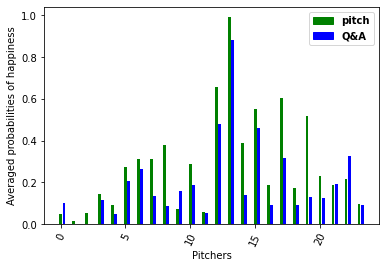

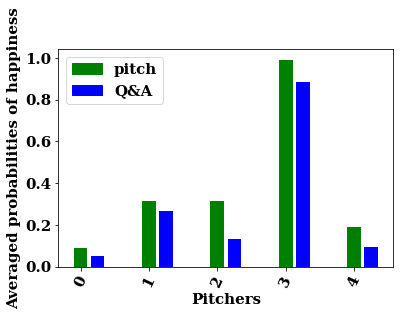

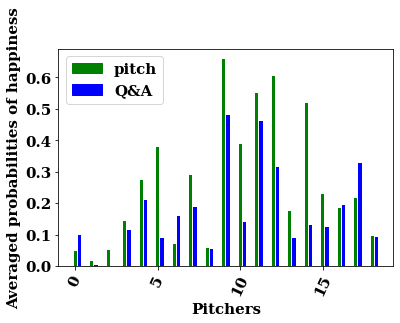

In [0]:
#@title plot for mean probabilities of happiness;for females and males


#plt.title('Plot happy vs not happy for the insensity of the 17 auction units')
X = np.arange(24)
L = np.arange(24)
plt.bar(X , mean_pitch.squeeze(), color = 'g', width = 0.20)
plt.bar(L+0.25 ,mean_q_a.squeeze(), color = 'b', width = 0.20)
plt.xticks(rotation=65)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
colors = {'pitch':'green', 'Q&A':'blue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.ylabel('Averaged probabilities of happiness')
plt.rc('font', family='serif', size=15)
plt.xlabel('Pitchers')

#fig = plt.gcf()
#fig.set_size_inches(8, 6)
#fig.savefig('mean_pitch_qa.png', dpi=80)

plt.show()

#plot for female pitchers
x = np.array(gender)
X = np.arange(5)
L = np.arange(5)
plt.bar(X , mean_pitch.squeeze()[np.where(x==1)], color = 'g', width = 0.20)
plt.bar(L+0.25 ,mean_q_a.squeeze()[np.where(x==1)], color = 'b', width = 0.20)
plt.xticks(rotation=65)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
colors = {'pitch':'green', 'Q&A':'blue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.ylabel('Averaged probabilities of happiness')
plt.rc('font', family='serif', size=15)
plt.xlabel('Pitchers')

#fig = plt.gcf()
#fig.set_size_inches(8, 6)
#fig.savefig('female pitchers.png', dpi=80)

plt.show()

#plot for male pitchers 
X = np.arange(19)
L = np.arange(19)
plt.bar(X , mean_pitch.squeeze()[np.where(x==0)], color = 'g', width = 0.20)
plt.bar(L+0.25 ,mean_q_a.squeeze()[np.where(x==0)], color = 'b', width = 0.20)
plt.xticks(rotation=65)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
colors = {'pitch':'green', 'Q&A':'blue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.ylabel('Averaged probabilities of happiness')
plt.rc('font', family='serif', size=15)
plt.xlabel('Pitchers')

#fig = plt.gcf()
#fig.set_size_inches(8, 6)
#fig.savefig('male pitchers.png', dpi=80)

plt.show()


##Second research question; Linear regression

In [0]:
#@title standardize data and make dataframe

scaler = StandardScaler()
x_d = scaler.fit_transform(X_data)
#hsplit(x_d,)
x_s = np.hstack((x_d[:,:4],np.array(gender).reshape(24,1), x_d[:,5:]))


stat_dif= pd.DataFrame(x_s[:,:5], columns = ['mean_dif', 'min_dif', 'max_dif', 'st_dif','gender'])
stat = pd.DataFrame(x_s[:,4:], columns = ['gender', 'mean_pitch', 'min_pitch', 'max_pitch', 
                                     'st_pitch', 'mean_q_a', 'min_q_a', 
                                     'max_q_a', 'st_q_a'])
stat['scores_probsuc']= scores_probsuc

In [0]:
#@title linear regression; probability to success on gender and mean_pitch

x = sm.add_constant(stat[['gender','mean_pitch']])
model = sm.OLS(scores_probsuc, x)
results = model.fit()
print(results.summary())

print('coefficient of determination:', results.rsquared)

print('adjusted coefficient of determination:', results.rsquared_adj)

print('regression coefficients:', results.params)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     2.190
Date:                Wed, 27 May 2020   Prob (F-statistic):              0.137
Time:                        21:32:40   Log-Likelihood:                -103.83
No. Observations:                  24   AIC:                             213.7
Df Residuals:                      21   BIC:                             217.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.3788      4.512      8.063      0.0

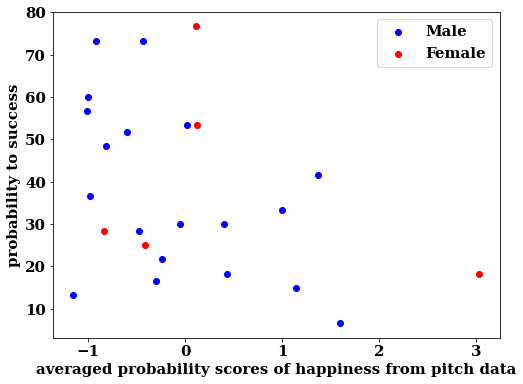

In [0]:
#@title plot for mean probability scores of happiness and probability to success 
female = stat.iloc[np.where(stat.iloc[:,0] == 1)[0]]
male = stat.iloc[np.where(stat.iloc[:,0] == 0)[0]]

plt.scatter(male["mean_pitch"] , male["scores_probsuc"], label = "Male", c = "blue")
plt.scatter(female["mean_pitch"] , female["scores_probsuc"], label = "Female", c = "red")
plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
plt.ylabel('probability to success')
plt.rc('font', family='serif', size=15)
plt.xlabel('averaged probability scores of happiness from pitch data')

#plt.show()

fig = plt.gcf()
fig.set_size_inches(8, 6)
fig.savefig('mean probability scores of happiness.png', dpi=80)

In [0]:
#@title linear regression for mean difference
x = sm.add_constant(stat_dif[['mean_dif']])
model = sm.OLS(scores_probsuc, x)
results = model.fit()
print(results.summary())

print('coefficient of determination:', results.rsquared)

print('adjusted coefficient of determination:', results.rsquared_adj)

print('regression coefficients:', results.params)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     1.340
Date:                Wed, 27 May 2020   Prob (F-statistic):              0.260
Time:                        21:35:08   Log-Likelihood:                -105.40
No. Observations:                  24   AIC:                             214.8
Df Residuals:                      22   BIC:                             217.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         37.9167      4.166      9.101      0.0

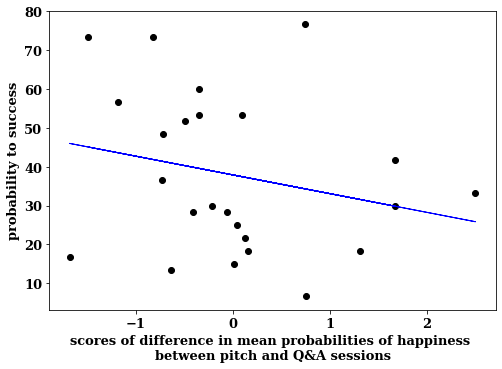

In [0]:
#@title plot of Regression fit

plt.scatter(stat_dif['mean_dif'], scores_probsuc,  color='black')
plt.plot(stat_dif['mean_dif'], results.predict(x), color='blue', linewidth=1)


plt.ylabel('probability to success')
plt.rc('font', family='serif', size=11)
plt.xlabel('scores of difference in mean probabilities of happiness \nbetween pitch and Q&A sessions')


fig = plt.gcf()
fig.set_size_inches(8, 5.5)
fig.savefig('score of difference in mean probabilities of happines.png', dpi=80)

#plt.show()

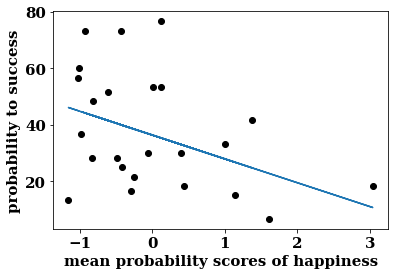

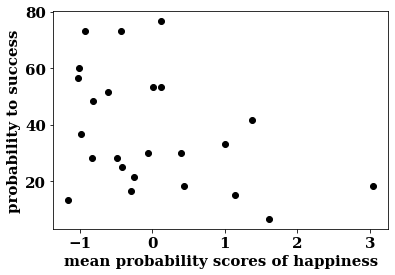

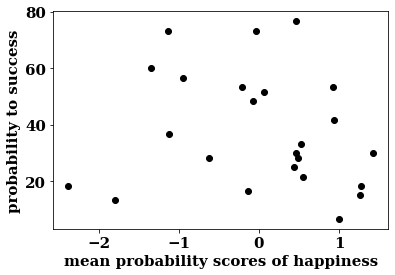

In [0]:
#@title various plots
plt.scatter(stat['mean_pitch'], scores_probsuc,  color='black')
plt.plot(stat['mean_pitch'], -8.4539 * stat['mean_pitch'] + 36.3788  )

plt.ylabel('probability to success')
plt.rc('font', family='serif', size=15)
plt.xlabel('mean probability scores of happiness')

plt.show()

# Plot outputs

plt.scatter(stat['mean_pitch'], scores_probsuc,  color='black')


plt.ylabel('probability to success')
plt.rc('font', family='serif', size=15)
plt.xlabel('mean probability scores of happiness')

plt.show()

# Plot outputs

plt.scatter(stat['st_pitch'], scores_probsuc,  color='black')
#plt.plot(X_data[:,5], lr.predict(X_data[:,4:13]), color='blue', linewidth=1)

plt.ylabel('probability to success')
plt.rc('font', family='serif', size=15)
plt.xlabel('sd of probability scores of happiness')

plt.show()